## U-Netセグメンテーション

- 参考  
datasetクラスとUNet_2Dクラス  
https://qiita.com/gensal/items/03e9a6d0f7081e77ba37



In [1]:
import os

import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


### データ読み込みの準備
テキストファイルをもとにセグメンテーション用画像のパスのリストを作る  


In [2]:
train_path = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
val_path = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

def txt_to_pathlist(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]

        image_paths = ["./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/"+fn+".jpg" for fn in lines]
        label_paths = ["./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass/"+fn+".png" for fn in lines]
    return image_paths, label_paths

train_image_paths, train_label_paths = txt_to_pathlist(train_path)
v_image_paths, v_label_paths = txt_to_pathlist(val_path)
middle = len(v_image_paths)//2
val_image_paths = v_image_paths[:middle]
val_label_paths = v_label_paths[:middle]
test_image_paths = v_image_paths[middle:]
test_label_paths = v_label_paths[middle:]

print(len(train_image_paths), len(val_image_paths), len(test_image_paths))


1464 724 725


データセットクラスの作成

In [3]:
class VOCDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.resize((256,256)) 
        image = np.asarray(image)
        image = image/255
        image = torch.from_numpy(image.astype(np.float32)).clone()
        image = image.permute(2,0,1) 

        label = Image.open(self.label_paths[idx])
        label = label.resize((256,256))
        label = np.asarray(label)
        label = np.where(label == 255, 0, label) 
        label = torch.from_numpy(label).long().clone()
        return image, label

In [4]:
training_data = VOCDataset(train_image_paths, train_label_paths)
validation_data = VOCDataset(val_image_paths, val_label_paths)
test_data = VOCDataset(test_image_paths, test_label_paths)

In [5]:
batch_size = 16

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([16, 3, 256, 256])
Shape of y:  torch.Size([16, 256, 256]) torch.int64


### U-Netの定義

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding="same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(3, 64, 64)
        self.TCB2 = TwoConvBlock(64, 128, 128)
        self.TCB3 = TwoConvBlock(128, 256, 256)
        self.TCB4 = TwoConvBlock(256, 512, 512)
        self.TCB5 = TwoConvBlock(512, 1024, 1024)
        self.TCB6 = TwoConvBlock(1024, 512, 512)
        self.TCB7 = TwoConvBlock(512, 256, 256)
        self.TCB8 = TwoConvBlock(256, 128, 128)
        self.TCB9 = TwoConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        
        self.UC1 = UpConv(1024, 512) 
        self.UC2 = UpConv(512, 256) 
        self.UC3 = UpConv(256, 128) 
        self.UC4= UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, 21, kernel_size = 1)
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim = 1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim = 1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim = 1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim = 1)
        x = self.TCB9(x)

        x = self.conv1(x)
        #x = self.soft(x)

        return x
    
model = UNet_2D().to(device)
#print(model)

Using cuda device


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

平均dice, 平均accuracyの計算

In [38]:
def calc_metrics(pred, tgt):
    mean_dice_list = []
    mean_acc_list = []
    for i in range(len(pred)):
        present_dice_list = []
        present_acc_list = []
        for c in range(21):
            #onehot化
            tgt_mask = F.one_hot(tgt[i], 21)
            pred_mask = torch.argmax(pred[i], dim=0)
            pred_mask = F.one_hot(pred_mask, 21)

            tgt_mask = tgt_mask[:,:,c]
            pred_mask = pred_mask[:,:,c]
            if tgt_mask.sum().item() != 0:
                tp = torch.logical_and(tgt_mask, pred_mask).sum().item()
                fp = torch.logical_and(~tgt_mask, pred_mask).sum().item()
                fn = torch.logical_and(tgt_mask, ~pred_mask).sum().item()
                tn = torch.logical_and(~tgt_mask, ~pred_mask).sum().item()
                dice = 2*tp/(2*tp+fp+fn)
                acc = (tp+tn)/(tp+tn+fp+fn)
                present_dice_list.append(dice)
                present_acc_list.append(acc)
        mean_dice_list.append(np.mean(present_dice_list))
        mean_acc_list.append(np.mean(present_acc_list))
    return mean_dice_list, mean_acc_list

def label_map_to_image(label_map, color_map):
    h, w = label_map.shape
    color_image = np.zeros((h,w,3), dtype=np.uint8)
    for label, color in enumerate(color_map):
        color_image[label_map == label] = color
    return Image.fromarray(color_image)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss /= size
    return epoch_loss

In [10]:
def validation(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss = 0
    dices = []
    accs = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            dice_list, acc_list = calc_metrics(pred, y)
            dices += dice_list
            accs += acc_list

    validation_loss /= size
    mdice = np.mean(dices)
    macc = np.mean(accs)
    print(f"Validation Error: \n mean Dice: {(mdice):.3f}, mean acc: {(macc):.3f}, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    dices = []
    accs = []
    save_dir = "./result/segmentation/"
    os.makedirs(save_dir, exist_ok=True)
    i = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            dice_list, acc_list = calc_metrics(pred, y)
            dices += dice_list
            accs += acc_list
            for p in pred:
                pred_map = p.cpu()
                pred_map = torch.argmax(pred_map, dim=0)
                pred_map = np.array(pred_map)
                pred_map = label_map_to_image(pred_map)
                pred_map.save(save_dir+str(i)+".jpg")
                i+=1
    test_loss /= size
    mdice = np.mean(dices)
    macc = np.mean(accs)
    print(f"Test Error: \n mean Dice: {(mdice):.3f}, mean acc: {(macc):.3f}, Avg loss: {test_loss:>8f} \n")

validation損失をもとに最適epochを決定


In [12]:
epochs = 10
min_loss = 1000
model_path = "model/unet/"
result_dir = "result/"

os.makedirs(model_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), "./model/model_"+str(t+1)+".pth")
print(best_epoch)

model = UNet_2D().to(device)
model.load_state_dict(torch.load("model/model_"+str(best_epoch)+".pth"))
test(test_dataloader, model)

print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 3.219588  [    0/ 1464]
loss: 3.038038  [  400/ 1464]
loss: 2.899683  [  800/ 1464]
loss: 2.742297  [ 1200/ 1464]
Validation Error: 
 mean Dice: 0.168, mean acc: 0.718, Avg loss: 0.171196 

Epoch 2
-------------------------------
loss: 2.580562  [    0/ 1464]
loss: 2.455514  [  400/ 1464]
loss: 2.279221  [  800/ 1464]
loss: 2.225324  [ 1200/ 1464]
Validation Error: 
 mean Dice: 0.205, mean acc: 0.712, Avg loss: 0.143104 

Epoch 3
-------------------------------
loss: 2.207865  [    0/ 1464]
loss: 2.130936  [  400/ 1464]
loss: 1.890719  [  800/ 1464]
loss: 1.849324  [ 1200/ 1464]
Validation Error: 
 mean Dice: 0.203, mean acc: 0.708, Avg loss: 0.120113 

Epoch 4
-------------------------------
loss: 2.038502  [    0/ 1464]
loss: 1.796736  [  400/ 1464]
loss: 1.692066  [  800/ 1464]
loss: 1.676541  [ 1200/ 1464]
Validation Error: 
 mean Dice: 0.200, mean acc: 0.707, Avg loss: 0.105374 

Epoch 5
-------------------------------
loss: 1.693333  [    0/ 1464]
loss: 1.618194  [  400/ 14

損失グラフ作成

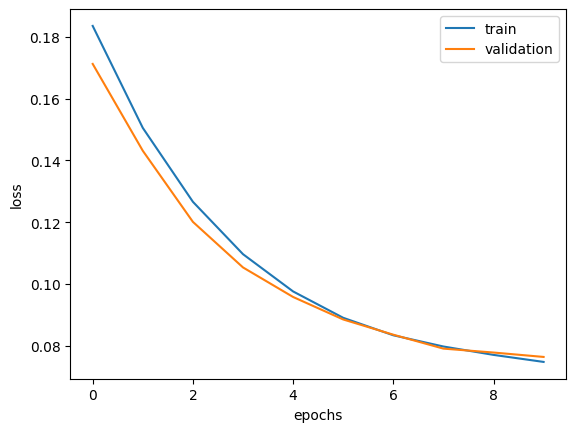

In [13]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


結果の評価

カラーマップ
https://gist.github.com/wllhf/a4533e0adebe57e3ed06d4b50c8419ae

In [39]:
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap
cmap = color_map()
from skimage.io import imshow
def color_map_viz():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()
#color_map_viz()
#color_map()


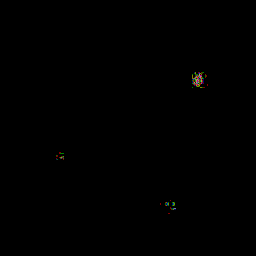

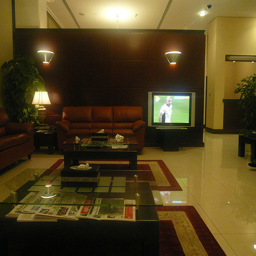

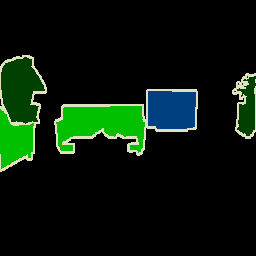

In [40]:
pred_label = Image.open("./result/segmentation/0.jpg")

pred_label = label_map_to_image(np.array(pred_label),cmap.tolist())

pred_label.show()

img = Image.open(test_image_paths[0])
img = img.resize((256,256)) 
img.show()

gt = Image.open(test_label_paths[0])
gt = gt.resize((256,256))
gt.show()